In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report
from sklearn.metrics import log_loss, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import pairwise_distances
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report
from sklearn.metrics import log_loss, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_data = pd.read_csv('./data.csv')
pd.options.display.max_columns = 1000

In [3]:
raw_data.head()

,visitor,session,browser,sessions_before,sessions_with_affil_before,affil_after_p1_prev_session,sessions_before_with_checkout,sessions_before_with_cart,sessions_before_with_product,daily_sessions,trialy_sessions,quintally_sessions,tenally_sessions,coupon_run_prev_ses_checkout_session,coupon_run_prev_ses_cart_session,coupon_run_prev_ses_product_session,time_spent,day_between_previous_session,daily_visitor,trialy_visitor,quintally_visitor,tenally_visitor,previous_session_cart,previous_session_checkout,previous_session_product,entry_home,entry_product,page_depth,first_page_affil,coupon_run_on_checkout,coupon_run_on_cart,coupon_run_on_product,products_viewed,mal_cb,coupon_run
0,00006362-4996-4898-9aae-21317547d39e,8196a21e-e172-414a-bebe-231bfd8019ab,IE,0,0,0,0,0,0,0,0,0,0,0,0,0,57443.71,0,0,0,0,0,0,0,0,1,0,14,0,0,0,0,5,0,0
1,00006362-4996-4898-9aae-21317547d39e,93660917-7a56-42f8-a59e-d06af115daad,IE,1,0,0,0,0,1,0,0,0,1,0,0,0,12772.00,8,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0
2,00006362-4996-4898-9aae-21317547d39e,8bf4bde4-6bf3-4fb8-ae03-0e52a9c41238,IE,2,0,0,0,0,1,1,0,0,1,0,0,0,11856.00,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,0000879b-5642-476a-b307-da1736aa0e23,61398de4-3c0b-4630-b7e8-09610d19935b,IE,0,0,0,0,0,0,0,0,0,0,0,0,0,114187.35,0,0,0,0,0,0,0,0,1,0,34,0,0,0,0,4,0,0
4,0000879b-5642-476a-b307-da1736aa0e23,62725745-7a89-46c7-a07d-4b745daffd69,IE,1,0,0,0,1,1,1,0,0,0,0,0,0,15562.00,0,1,0,0,0,1,0,1,1,0,2,0,0,0,0,0,0,0


# performance measurement

As this dataset is highly imbalanced(99:1) accuracy is not a correct measurment for this problem. we can achieve accuracy over 99% easily with this dataset.
So I considered RECALL as a performance measurement. Business undertanding would help us understande correct performance matrix and tune algorithms accordingly. 


# Data preparation

In [4]:
tst_idx = raw_data[(raw_data['coupon_run_on_cart']==1)|(raw_data['coupon_run_on_checkout']==1)|(raw_data['coupon_run_on_product']==1)]

In [5]:
test_df = []
for i in range(len(raw_data)):
    if(i in tst_idx.index):
        test_df.append(1)
    else:
        test_df.append(0)

test_df_arr = np.array(test_df)
raw_data['coupon_run'] = test_df_arr

# preliminary data analysis

In [6]:
raw_data[raw_data['coupon_run']==1].describe()

,sessions_before,sessions_with_affil_before,affil_after_p1_prev_session,sessions_before_with_checkout,sessions_before_with_cart,sessions_before_with_product,daily_sessions,trialy_sessions,quintally_sessions,tenally_sessions,coupon_run_prev_ses_checkout_session,coupon_run_prev_ses_cart_session,coupon_run_prev_ses_product_session,time_spent,day_between_previous_session,daily_visitor,trialy_visitor,quintally_visitor,tenally_visitor,previous_session_cart,previous_session_checkout,previous_session_product,entry_home,entry_product,page_depth,first_page_affil,coupon_run_on_checkout,coupon_run_on_cart,coupon_run_on_product,products_viewed,mal_cb,coupon_run
count,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8.624000e+03,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.0
mean,2.625000,0.827226,1.321197,0.169991,0.800325,1.711155,0.527713,0.439471,0.306238,0.609810,0.008581,0.143785,0.164889,8.719834e+05,1.774003,0.357375,0.152597,0.065051,0.079661,0.214634,0.040816,0.483186,0.390770,0.249536,23.048237,0.122565,0.064355,0.455705,0.520524,4.520292,0.085111,1.0
std,4.400316,1.881524,3.990745,0.591877,1.798441,2.809039,0.929460,1.069888,0.983113,1.769312,0.093488,0.547808,0.525752,1.117128e+07,3.828949,0.479254,0.359620,0.246630,0.270784,0.410592,0.197876,0.499746,0.490322,0.432770,21.273613,0.327956,0.245399,0.498063,0.499608,5.976998,0.279063,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.220000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.827496e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.534490e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1.0
75%,3.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,7.070520e+04,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,0.000000,0.000000,1.000000,1.000000,6.000000,0.000000,1.0
max,82.000000,64.000000,94.000000,10.000000,31.000000,35.000000,15.000000,24.000000,53.000000,58.000000,2.000000,11.000000,6.000000,6.648551e+08,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,238.000000,1.000000,1.000000,1.000000,1.000000,131.000000,1.000000,1.0


In [7]:
raw_data[raw_data['coupon_run']==0].describe()

,sessions_before,sessions_with_affil_before,affil_after_p1_prev_session,sessions_before_with_checkout,sessions_before_with_cart,sessions_before_with_product,daily_sessions,trialy_sessions,quintally_sessions,tenally_sessions,coupon_run_prev_ses_checkout_session,coupon_run_prev_ses_cart_session,coupon_run_prev_ses_product_session,time_spent,day_between_previous_session,daily_visitor,trialy_visitor,quintally_visitor,tenally_visitor,previous_session_cart,previous_session_checkout,previous_session_product,entry_home,entry_product,page_depth,first_page_affil,coupon_run_on_checkout,coupon_run_on_cart,coupon_run_on_product,products_viewed,mal_cb,coupon_run
count,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,7.665740e+05,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.000000,766574.0,766574.0,766574.0,766574.000000,766574.000000,766574.0
mean,3.335405,0.108277,0.149303,0.150522,0.571230,1.951174,0.616539,0.592003,0.384331,0.774454,0.001818,0.015278,0.014938,2.640935e+06,2.061759,0.345136,0.157099,0.069411,0.096734,0.124655,0.033750,0.456744,0.402159,0.169155,8.251514,0.012039,0.0,0.0,0.0,1.869135,0.035747,0.0
std,8.495479,0.731061,1.154949,0.995264,1.881794,5.239577,2.030250,2.732810,1.743419,2.245324,0.043273,0.166194,0.153295,8.056131e+07,4.142459,0.475413,0.363894,0.254153,0.295596,0.330327,0.180586,0.498126,0.491978,0.374889,13.348851,0.109061,0.0,0.0,0.0,7.787498,0.185660,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.347605e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.181565e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0
75%,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.802645e+04,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,10.000000,0.000000,0.0,0.0,0.0,2.000000,0.000000,0.0
max,292.000000,65.000000,117.000000,64.000000,81.000000,244.000000,47.000000,95.000000,95.000000,64.000000,2.000000,9.000000,7.000000,6.084348e+10,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,2303.000000,1.000000,0.0,0.0,0.0,2303.000000,1.000000,0.0


In [9]:
final_data = raw_data.drop(['visitor','session','browser','coupon_run_on_cart','coupon_run_on_checkout','coupon_run_on_product'],axis=1)

In [10]:
final_data.shape

(775198, 29)

# PCA visualization

## Observations:
No any conclusion from PCA visualization as both classed overlaps. 
although few outliers found during analysis but did not remove them as I was not sure because lack of domain knowledge.

In [11]:
X = final_data.iloc[:,:final_data.shape[1]-1]
Y = final_data.iloc[:,final_data.shape[1]-1]

processed_data = X

# Anomoly Detection

 As the class ratio is 99:1 this can also be posed as anomoly detection problem. I tested few anomloy detection algorithms and algorithms partially succeeded in finding anomoly. Took prediction from this algorithms as a additional features in training dataset. Tried few outlier/anomoly dection algorithms.

In [12]:
outliers_fraction = 0.0112

In [22]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(X)
data = pd.DataFrame(np_scaled)

# using Isolation Forest

In [14]:
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)

C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.0112,
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=None, verbose=0)

In [15]:
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)

C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.0112,
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=None, verbose=0)

In [16]:
processed_data['anomalyIF'] = pd.Series(model.predict(data))
processed_data['anomalyIF'] = processed_data['anomalyIF'].map( {1: 0, -1: 1} )

C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


# Using EllipticEnvelope

In [32]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
envelope.fit(X)


EllipticEnvelope(assume_centered=False, contamination=0.0112,
         random_state=None, store_precision=True, support_fraction=None)

In [33]:
processed_data['anomalyEE'] = envelope.predict(X)

In [34]:
processed_data['anomalyEE'] = processed_data['anomalyEE'].map( {1: 0, -1: 1} )

In [30]:
#processed_data.drop(columns='anomalyEE',inplace=True)

# Clustering



In [36]:
kmeans_mini_batch = MiniBatchKMeans(n_clusters=25, batch_size=20000,random_state=0).fit(processed_data)

In [37]:
processed_data['cluster']=kmeans_mini_batch.predict(X)

# Oversampling with SMOTE


In [38]:
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(processed_data, Y, test_size=0.3, random_state=42)

In [41]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train_imb,y_train_imb)

In [42]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

In [43]:
scal = StandardScaler()
X_train_smote = scal.fit_transform(X_train_smote)
X_test_smote = scal.transform(X_test_smote)


In [44]:
x_test_imb = scal.transform(X_test_imb)

## Beroulli Naive Bayes

In [48]:
optimal_nb_sm = BernoulliNB(alpha=100)
lp = optimal_nb_sm.fit(X_train_smote, y_train_smote)

In [49]:

nb_prd_sm = optimal_nb_sm.predict(x_test_imb)

acc = accuracy_score(y_test_imb, nb_prd_sm) * 100
print('\nThe accuracy of the Bernoulli Naive Bayes is {}' , acc)

print("Classification Report")
print(classification_report(y_test_imb,nb_prd_sm))


The accuracy of the Bernoulli Naive Bayes is {} 87.3688510491916
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    229969
           1       0.05      0.53      0.09      2591

   micro avg       0.87      0.87      0.87    232560
   macro avg       0.52      0.71      0.51    232560
weighted avg       0.98      0.87      0.92    232560



True positive rate: 53.37707448861444
False positive rate: 12.248172579782493
True negative rate: 87.75182742021751
False negative rate: 46.62292551138557


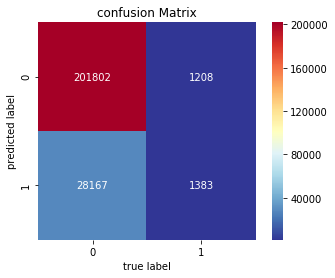

In [50]:
mat = confusion_matrix(y_test_imb,nb_prd_sm)
tn, fp, fn, tp = confusion_matrix(y_test_imb,nb_prd_sm).ravel()

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['0','1'], yticklabels=['0','1'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

print("True positive rate:",(tp/(tp+fn))*100)
print("False positive rate:",(fp/(tn+fp))*100)
print("True negative rate:",(tn/(tn+fp))*100)
print("False negative rate:",(fn/(tp+fn))*100)

## Logistic regression

In [51]:
optimal_lr_sm = LogisticRegression(C=100,class_weight='balanced')
lp = optimal_lr_sm.fit(X_train_smote, y_train_smote)


In [52]:
log_prd_sm = optimal_lr_sm.predict(x_test_imb)

acc = accuracy_score(y_test_imb, log_prd_sm) * 100
print('\nThe accuracy of the Logistic Regression is {}' , acc)

print("Classification Report")
print(classification_report(y_test_imb,log_prd_sm))


The accuracy of the Logistic Regression is {} 86.40393876848985
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    229969
           1       0.06      0.73      0.11      2591

   micro avg       0.86      0.86      0.86    232560
   macro avg       0.53      0.80      0.52    232560
weighted avg       0.99      0.86      0.92    232560



True positive rate: 73.4851408722501
False positive rate: 13.450508546804135
True negative rate: 86.54949145319587
False negative rate: 26.5148591277499


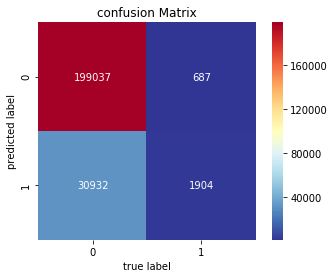

In [53]:
mat = confusion_matrix(y_test_imb,log_prd_sm)
tn, fp, fn, tp = confusion_matrix(y_test_imb,log_prd_sm).ravel()

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['0','1'], yticklabels=['0','1'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

print("True positive rate:",(tp/(tp+fn))*100)
print("False positive rate:",(fp/(tn+fp))*100)
print("True negative rate:",(tn/(tn+fp))*100)
print("False negative rate:",(fn/(tp+fn))*100)

## Stacking Classifier

In [55]:
lr =LogisticRegression(C=100)
sclf = StackingClassifier(classifiers=[optimal_nb_sm,optimal_lr_sm], meta_classifier=lr, use_probas=False)
#sclf2 = StackingClassifier(classifiers=[sclf,optimal_nb_sm,optimal_lr_sm], meta_classifier=lr, use_probas=False)
sclf = sclf.fit(X_train_smote, y_train_smote)

In [57]:
sclf_prd_smote = sclf.predict(x_test_imb)

In [58]:
acc = accuracy_score(y_test_imb, sclf_prd_smote) * 100
print('\nThe accuracy of the xgboost is {}' , acc)

print("Classification Report")
print(classification_report(y_test_imb,sclf_prd_smote))


The accuracy of the xgboost is {} 81.21216030271758
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    229969
           1       0.04      0.77      0.08      2591

   micro avg       0.81      0.81      0.81    232560
   macro avg       0.52      0.79      0.49    232560
weighted avg       0.99      0.81      0.89    232560



True positive rate: 77.38324971053648
False positive rate: 18.744700372658922
True negative rate: 81.25529962734107
False negative rate: 22.61675028946353


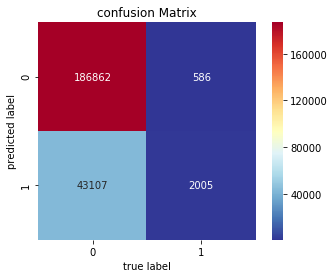

In [59]:

mat = confusion_matrix(y_test_imb,sclf_prd_smote)
tn, fp, fn, tp = confusion_matrix(y_test_imb,sclf_prd_smote).ravel()

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['0','1'], yticklabels=['0','1'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

print("True positive rate:",(tp/(tp+fn))*100)
print("False positive rate:",(fp/(tn+fp))*100)
print("True negative rate:",(tn/(tn+fp))*100)
print("False negative rate:",(fn/(tp+fn))*100)

# Conclusion:

<ol>
    <li> Stacking classifer worked very well with RECALL of 77%.</li>
    <li> Fair False positive and True positive rate achieved as we have too muchc imbalaced data.
 </ol>